## 特征工程与机器学习建模

### 自定义工具函数库

In [1]:
#coding=utf-8
import  pandas as pd
import numpy as np
import scipy as sp


#文件读取
def read_csv_file(f,logging=False):
    print("============================读取数据========================",f)
    print("======================我是萌萌哒分界线========================")
    data = pd.read_csv(f)
    if logging:
        print(data.head(5))
        print(f,"  包含以下列....")
        print(data.columns.values)
        print(data.describe())
        print(data.info())
    return  data

#第一类编码
def categories_process_first_class(cate):
    cate = str(cate)
    if len(cate)==1:
        if int(cate)==0:
            return 0
    else:
        return int(cate[0])

#第2类编码
def categories_process_second_class(cate):
    cate = str(cate)
    if len(cate)<3:
        return 0
    else:
        return int(cate[1:])

#年龄处理，切段
def age_process(age):
    age = int(age)
    if age==0:
        return 0
    elif age<15:
        return 1
    elif age<25:
        return 2
    elif age<40:
        return 3
    elif age<60:
        return 4
    else:
        return 5

#省份处理
def process_province(hometown):
    hometown = str(hometown)
    province = int(hometown[0:2])
    return province

#城市处理
def process_city(hometown):
    hometown = str(hometown)
    if len(hometown)>1:
        province = int(hometown[2:])
    else:
        province = 0
    return province

#几点钟
def get_time_day(t):
    t = str(t)
    t=int(t[0:2])
    return t

#一天切成4段
def get_time_hour(t):
    t = str(t)
    t=int(t[2:4])
    if t<6:
        return 0
    elif t<12:
        return 1
    elif t<18:
        return 2
    else:
        return 3

#评估与计算logloss
def logloss(act, pred):
  epsilon = 1e-15
  pred = sp.maximum(epsilon, pred)
  pred = sp.minimum(1-epsilon, pred)
  ll = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
  ll = ll * -1.0/len(act)
  return ll

### 特征工程+随机森林建模

#### import 库

In [2]:
#coding=utf-8
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

#### 读取train_data和ad
#### 特征工程

In [15]:
#['label' 'clickTime' 'conversionTime' 'creativeID' 'userID' 'positionID' 'connectionType' 'telecomsOperator']
train_data = read_csv_file('./data/train.csv',logging=True)

#['creativeID' 'adID' 'camgaignID' 'advertiserID' 'appID' 'appPlatform']
ad = read_csv_file('./data/ad.csv',logging=True)

============================读取数据======================== ./data/train.csv
======================我是萌萌哒分界线========================
   label  clickTime  conversionTime  creativeID   userID  positionID  \
0      0     170000             NaN        3089  2798058         293   
1      0     170000             NaN        1259   463234        6161   
2      0     170000             NaN        4465  1857485        7434   
3      0     170000             NaN        1004  2038823         977   
4      0     170000             NaN        1887  2015141        3688   

   connectionType  telecomsOperator  
0               1                 1  
1               1                 2  
2               4                 1  
3               1                 1  
4               1                 1  
./data/train.csv   包含以下列....
['label' 'clickTime' 'conversionTime' 'creativeID' 'userID' 'positionID'
 'connectionType' 'telecomsOperator']
              label     clickTime  conversionTime    creativeID       

In [20]:
#app
app_categories = read_csv_file('./data/app_categories.csv',logging=True)
app_categories["app_categories_first_class"] = app_categories['appCategory'].apply(categories_process_first_class)
app_categories["app_categories_second_class"] = app_categories['appCategory'].apply(categories_process_second_class)

============================读取数据======================== ./data/app_categories.csv
======================我是萌萌哒分界线========================
   appID  appCategory
0     14            2
1     25          203
2     68          104
3     75          402
4     83          203
./data/app_categories.csv   包含以下列....
['appID' 'appCategory']
               appID    appCategory
count  217041.000000  217041.000000
mean   137220.306472     161.856133
std    105340.872671     157.746571
min        14.000000       0.000000
25%     54585.000000       0.000000
50%    111520.000000     106.000000
75%    195882.000000     301.000000
max    433269.000000     503.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217041 entries, 0 to 217040
Data columns (total 2 columns):
appID          217041 non-null int64
appCategory    217041 non-null int64
dtypes: int64(2)
memory usage: 3.3 MB
None


In [5]:
app_categories.head()

,appID,appCategory,app_categories_first_class,app_categories_second_class
0,14,2,NaN,0
1,25,203,2.0,3
2,68,104,1.0,4
3,75,402,4.0,2
4,83,203,2.0,3


In [2]:
user = read_csv_file('./data/user.csv',logging=False)

============================读取数据======================== ./data/user.csv
======================我是萌萌哒分界线========================


In [3]:
user.columns

Index([u'userID', u'age', u'gender', u'education', u'marriageStatus',
       u'haveBaby', u'hometown', u'residence'],
      dtype='object')

In [12]:
user[user.age!=0].describe()

,userID,age,gender,education,marriageStatus,haveBaby,hometown,residence,age_process,hometown_province,hometown_city,residence_province,residence_city
count,2.510847e+06,2.510847e+06,2.510847e+06,2.510847e+06,2.510847e+06,2.510847e+06,2.510847e+06,2.510847e+06,2.510847e+06,2.510847e+06,2.510847e+06,2.510847e+06,2.510847e+06
mean,1.393745e+06,2.277593e+01,1.410284e+00,1.975580e+00,1.017286e+00,3.033893e-01,7.372152e+02,9.797279e+02,2.252490e+00,2.312017e+01,2.873596e+00,2.879952e+01,3.668985e+00
std,8.105652e+05,9.675687e+00,5.321244e-01,1.577530e+00,9.508679e-01,8.098684e-01,7.746096e+02,7.855014e+02,8.460603e-01,2.472208e+01,3.033409e+00,2.273902e+01,2.994358e+00
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.903605e+05,1.500000e+01,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.050000e+02,2.000000e+00,0.000000e+00,0.000000e+00,1.300000e+01,1.000000e+00
50%,1.388503e+06,2.100000e+01,1.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,5.030000e+02,8.030000e+02,2.000000e+00,1.600000e+01,2.000000e+00,2.000000e+01,3.000000e+00
75%,2.095096e+06,2.800000e+01,2.000000e+00,3.000000e+00,2.000000e+00,0.000000e+00,1.301000e+03,1.513000e+03,3.000000e+00,3.000000e+01,5.000000e+00,4.000000e+01,6.000000e+00
max,2.805118e+06,8.000000e+01,2.000000e+00,7.000000e+00,3.000000e+00,6.000000e+00,3.401000e+03,3.401000e+03,5.000000e+00,9.100000e+01,1.600000e+01,9.100000e+01,1.800000e+01


In [10]:
import matplotlib.pyplot as plt
user.age.value_counts()

0     294271
15    150175
16    120322
17    115704
19    115692
13    114651
20    112301
18    110549
14    107356
25     99378
21     96306
26     92987
22     91733
12     88838
23     87728
27     84934
28     80358
24     79479
11     78679
29     68688
30     55187
31     47475
33     43033
32     41638
10     39061
34     34062
35     33106
36     29333
37     26512
38     21280
       ...  
6       3924
5       3395
54      2193
55      2111
4       1959
56      1795
57      1771
58      1527
59      1362
60      1100
61       923
62       412
63       292
66       285
65       266
64       234
67       220
80       165
68       145
69       124
70       123
71       104
78        89
73        87
74        86
76        85
75        81
72        77
77        72
79        55
Name: age, Length: 81, dtype: int64

In [11]:
#user
user = read_csv_file('./data/user.csv',logging=True)
user['age_process'] = user['age'].apply(age_process)
user["hometown_province"] = user['hometown'].apply(process_province)
user["hometown_city"] = user['hometown'].apply(process_city)
user["residence_province"] = user['residence'].apply(process_province)
user["residence_city"] = user['residence'].apply(process_city)

============================读取数据======================== ./data/user.csv
======================我是萌萌哒分界线========================
   userID  age  gender  education  marriageStatus  haveBaby  hometown  \
0       1   42       1          0               2         0       512   
1       2   18       1          5               1         0      1403   
2       3    0       2          4               0         0         0   
3       4   21       2          5               3         0       607   
4       5   22       2          0               0         0         0   

   residence  
0        503  
1       1403  
2          0  
3        607  
4       1301  
./data/user.csv   包含以下列....
['userID' 'age' 'gender' 'education' 'marriageStatus' 'haveBaby' 'hometown'
 'residence']
             userID           age        gender     education  marriageStatus  \
count  2.805118e+06  2.805118e+06  2.805118e+06  2.805118e+06    2.805118e+06   
mean   1.402560e+06  2.038662e+01  1.294072e+00  1.889235e+00  

In [13]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2805118 entries, 0 to 2805117
Data columns (total 13 columns):
userID                int64
age                   int64
gender                int64
education             int64
marriageStatus        int64
haveBaby              int64
hometown              int64
residence             int64
age_process           int64
hometown_province     int64
hometown_city         int64
residence_province    int64
residence_city        int64
dtypes: int64(13)
memory usage: 278.2 MB


In [14]:
user.head()

,userID,age,gender,education,marriageStatus,haveBaby,hometown,residence,age_process,hometown_province,hometown_city,residence_province,residence_city
0,1,42,1,0,2,0,512,503,4,51,2,50,3
1,2,18,1,5,1,0,1403,1403,2,14,3,14,3
2,3,0,2,4,0,0,0,0,0,0,0,0,0
3,4,21,2,5,3,0,607,607,2,60,7,60,7
4,5,22,2,0,0,0,0,1301,2,0,0,13,1


In [16]:
train_data.head()

,label,clickTime,conversionTime,creativeID,userID,positionID,connectionType,telecomsOperator
0,0,170000,NaN,3089,2798058,293,1,1
1,0,170000,NaN,1259,463234,6161,1,2
2,0,170000,NaN,4465,1857485,7434,4,1
3,0,170000,NaN,1004,2038823,977,1,1
4,0,170000,NaN,1887,2015141,3688,1,1


In [17]:
train_data['clickTime_day'] = train_data['clickTime'].apply(get_time_day)
train_data['clickTime_hour']= train_data['clickTime'].apply(get_time_hour)

### 合并数据

In [21]:
#train data
train_data['clickTime_day'] = train_data['clickTime'].apply(get_time_day)
train_data['clickTime_hour']= train_data['clickTime'].apply(get_time_hour)
# train_data['conversionTime_day'] = train_data['conversionTime'].apply(get_time_day)
# train_data['conversionTime_hour'] = train_data['conversionTime'].apply(get_time_hour)


#test_data
test_data = read_csv_file('./data/test.csv', True)
test_data['clickTime_day'] = test_data['clickTime'].apply(get_time_day)
test_data['clickTime_hour']= test_data['clickTime'].apply(get_time_hour)
# test_data['conversionTime_day'] = test_data['conversionTime'].apply(get_time_day)
# test_data['conversionTime_hour'] = test_data['conversionTime'].apply(get_time_hour)


train_user = pd.merge(train_data,user,on='userID')
train_user_ad = pd.merge(train_user,ad,on='creativeID')
train_user_ad_app = pd.merge(train_user_ad,app_categories,on='appID')

============================读取数据======================== ./data/test.csv
======================我是萌萌哒分界线========================
   instanceID  label  clickTime  creativeID   userID  positionID  \
0           1     -1     310000        3745  1164848        3451   
1           2     -1     310000        2284  2127247        1613   
2           3     -1     310000        1456  2769125        5510   
3           4     -1     310000        4565     9762        4113   
4           5     -1     310000          49  2513636        3615   

   connectionType  telecomsOperator  
0               1                 3  
1               1                 3  
2               2                 1  
3               2                 3  
4               1                 3  
./data/test.csv   包含以下列....
['instanceID' 'label' 'clickTime' 'creativeID' 'userID' 'positionID'
 'connectionType' 'telecomsOperator']
          instanceID     label      clickTime     creativeID        userID  \
count  338489.000000  

In [22]:
train_user_ad_app.head()

,label,clickTime,conversionTime,creativeID,userID,positionID,connectionType,telecomsOperator,clickTime_day,clickTime_hour,...,residence_province,residence_city,adID,camgaignID,advertiserID,appID,appPlatform,appCategory,app_categories_first_class,app_categories_second_class
0,0,170000,NaN,3089,2798058,293,1,1,17,0,...,13,1,1321,83,10,434,1,108,1.0,8
1,0,170001,NaN,3089,195578,3659,0,2,17,0,...,13,1,1321,83,10,434,1,108,1.0,8
2,0,170014,NaN,3089,1462213,3659,0,3,17,0,...,13,1,1321,83,10,434,1,108,1.0,8
3,0,170030,NaN,3089,1985880,5581,1,1,17,0,...,0,0,1321,83,10,434,1,108,1.0,8
4,0,170047,NaN,3089,2152167,5581,1,1,17,0,...,13,3,1321,83,10,434,1,108,1.0,8


In [23]:
train_user_ad_app.columns

Index([u'label', u'clickTime', u'conversionTime', u'creativeID', u'userID',
       u'positionID', u'connectionType', u'telecomsOperator', u'clickTime_day',
       u'clickTime_hour', u'age', u'gender', u'education', u'marriageStatus',
       u'haveBaby', u'hometown', u'residence', u'age_process',
       u'hometown_province', u'hometown_city', u'residence_province',
       u'residence_city', u'adID', u'camgaignID', u'advertiserID', u'appID',
       u'appPlatform', u'appCategory', u'app_categories_first_class',
       u'app_categories_second_class'],
      dtype='object')

### 取出数据和label

In [30]:
#特征部分
x_user_ad_app = train_user_ad_app.loc[:,['creativeID','userID','positionID',
 'connectionType','telecomsOperator','clickTime_day','clickTime_hour','age', 'gender' ,'education',
 'marriageStatus' ,'haveBaby' , 'residence' ,'age_process',
 'hometown_province', 'hometown_city','residence_province', 'residence_city',
 'adID', 'camgaignID', 'advertiserID', 'appID' ,'appPlatform' ,
 'app_categories_first_class' ,'app_categories_second_class']]

x_user_ad_app = x_user_ad_app.values
x_user_ad_app = np.array(x_user_ad_app,dtype='int32')

#标签部分
y_user_ad_app =train_user_ad_app.loc[:,['label']].values

### 随机森林建模&&特征重要度排序

In [31]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# print('Plot feature importances...')
# ax = lgb.plot_importance(gbm, max_num_features=10)
# plt.show()
# 用RF 计算特征重要度

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split

feat_labels = np.array(['creativeID','userID','positionID',
 'connectionType','telecomsOperator','clickTime_day','clickTime_hour','age', 'gender' ,'education',
 'marriageStatus' ,'haveBaby' , 'residence' ,'age_process',
 'hometown_province', 'hometown_city','residence_province', 'residence_city',
 'adID', 'camgaignID', 'advertiserID', 'appID' ,'appPlatform' ,
 'app_categories_first_class' ,'app_categories_second_class'])

forest = RandomForestClassifier(n_estimators=100,
                                random_state=0,
                                n_jobs=-1)

forest.fit(x_user_ad_app, y_user_ad_app.reshape(y_user_ad_app.shape[0],))
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

In [34]:
train_user_ad_app.shape

(3749528, 30)

In [35]:
importances

array([ 0.02791289,  0.16602297,  0.06583927,  0.00427082,  0.03330029,
        0.0773544 ,  0.03919645,  0.07549754,  0.01282422,  0.04891296,
        0.03127753,  0.01864926,  0.09910738,  0.01570717,  0.05421798,
        0.04832801,  0.06373888,  0.05784857,  0.01900962,  0.01561504,
        0.00836031,  0.00592996,  0.00088301,  0.00322788,  0.00696759])

In [ ]:
['creativeID','userID','positionID',
 'connectionType','telecomsOperator','clickTime_day','clickTime_hour','age', 'gender' ,'education',
 'marriageStatus' ,'haveBaby' , 'residence' ,'age_process',
 'hometown_province', 'hometown_city','residence_province', 'residence_city',
 'adID', 'camgaignID', 'advertiserID', 'appID' ,'appPlatform' ,
 'app_categories_first_class' ,'app_categories_second_class']

 1) userID                         0.166023
 2) residence                      0.099107
 3) clickTime_day                  0.077354
 4) age                            0.075498
 5) positionID                     0.065839
 6) residence_province             0.063739
 7) residence_city                 0.057849
 8) hometown_province              0.054218
 9) education                      0.048913
10) hometown_city                  0.048328
11) clickTime_hour                 0.039196
12) telecomsOperator               0.033300
13) marriageStatus                 0.031278
14) creativeID                     0.027913
15) adID                           0.019010
16) haveBaby                       0.018649
17) age_process                    0.015707
18) camgaignID                     0.015615
19) gender                         0.012824
20) advertiserID                   0.008360
21) app_categories_second_class    0.006968
22) appID                          0.005930
23) connectionType              

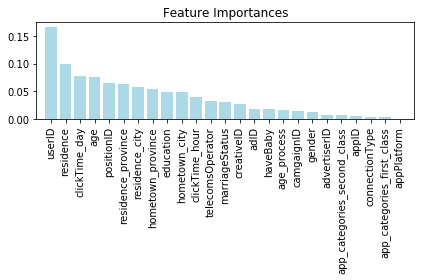

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
for f in range(x_user_ad_app.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(x_user_ad_app.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(x_user_ad_app.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, x_user_ad_app.shape[1]])
plt.tight_layout()
#plt.savefig('./random_forest.png', dpi=300)
plt.show()

### 随机森林调参

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid = {
              #'n_estimators': [100],
              'n_estimators': [10, 100, 500, 1000],
              'max_features':[0.6, 0.7, 0.8, 0.9]
             }

rf = RandomForestClassifier()
rfc = GridSearchCV(rf, param_grid, scoring = 'neg_log_loss', cv=3, n_jobs=2)
rfc.fit(x_user_ad_app, y_user_ad_app.reshape(y_user_ad_app.shape[0],))
print(rfc.best_score_)
print(rfc.best_params_)

### Xgboost调参

In [38]:
import xgboost as xgb

In [ ]:
import os
import numpy as np
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
os.environ["OMP_NUM_THREADS"] = "8"  #并行训练
rng = np.random.RandomState(4315)
import warnings
warnings.filterwarnings("ignore")

param_grid = {
              'max_depth': [3, 4, 5, 7, 9],
              'n_estimators': [10, 50, 100, 400, 800, 1000, 1200],
              'learning_rate': [0.1, 0.2, 0.3],
              'gamma':[0, 0.2],
              'subsample': [0.8, 1],
              'colsample_bylevel':[0.8, 1]
             }

xgb_model = xgb.XGBClassifier()
rgs = GridSearchCV(xgb_model, param_grid, n_jobs=-1)
rgs.fit(X, y)
print(rgs.best_score_)
print(rgs.best_params_)

### 正负样本比

In [13]:
positive_num = train_user_ad_app[train_user_ad_app['label']==1].values.shape[0]
negative_num = train_user_ad_app[train_user_ad_app['label']==0].values.shape[0]

negative_num/float(positive_num)

39.20424181338595

**我们可以看到正负样本数量相差非常大，数据严重unbalanced**

我们用Bagging修正过后，处理不均衡样本的B(l)agging来进行训练和实验。

In [14]:
from blagging import BlaggingClassifier

In [15]:
help(BlaggingClassifier)

Help on class BlaggingClassifier in module blagging:

class BlaggingClassifier(BaseBagging, sklearn.base.ClassifierMixin)
 |  A Bagging classifier.
 |  
 |  A Bagging classifier is an ensemble meta-estimator that fits base
 |  classifiers each on random subsets of the original dataset and then
 |  aggregate their individual predictions (either by voting or by averaging)
 |  to form a final prediction. Such a meta-estimator can typically be used as
 |  a way to reduce the variance of a black-box estimator (e.g., a decision
 |  tree), by introducing randomization into its construction procedure and
 |  then making an ensemble out of it.
 |  
 |  This algorithm encompasses several works from the literature. When random
 |  subsets of the dataset are drawn as random subsets of the samples, then
 |  this algorithm is known as Pasting [1]_. If samples are drawn with
 |  replacement, then the method is known as Bagging [2]_. When random subsets
 |  of the dataset are drawn as random subsets o

In [16]:
#处理unbalanced的classifier
classifier = BlaggingClassifier(n_jobs=-1)

In [17]:
classifier.fit(x_user_ad_app, y_user_ad_app)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BlaggingClassifier(base_estimator=None, bootstrap=True,
          bootstrap_features=False, max_features=1.0, max_samples=1.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)

In [ ]:
classifier.predict_proba(x_test_clean)

#### 预测

In [ ]:
test_data = pd.merge(test_data,user,on='userID')
test_user_ad = pd.merge(test_data,ad,on='creativeID')
test_user_ad_app = pd.merge(test_user_ad,app_categories,on='appID')

x_test_clean = test_user_ad_app.loc[:,['creativeID','userID','positionID',
 'connectionType','telecomsOperator','clickTime_day','clickTime_hour','age', 'gender' ,'education',
 'marriageStatus' ,'haveBaby' , 'residence' ,'age_process',
 'hometown_province', 'hometown_city','residence_province', 'residence_city',
 'adID', 'camgaignID', 'advertiserID', 'appID' ,'appPlatform' ,
 'app_categories_first_class' ,'app_categories_second_class']].values

x_test_clean = np.array(x_test_clean,dtype='int32')

result_predict_prob = []
result_predict=[]
for i in range(scale):
    result_indiv = clfs[i].predict(x_test_clean)
    result_indiv_proba = clfs[i].predict_proba(x_test_clean)[:,1]
    result_predict.append(result_indiv)
    result_predict_prob.append(result_indiv_proba)


result_predict_prob = np.reshape(result_predict_prob,[-1,scale])
result_predict = np.reshape(result_predict,[-1,scale])

result_predict_prob = np.mean(result_predict_prob,axis=1)
result_predict = max_count(result_predict)


result_predict_prob = np.array(result_predict_prob).reshape([-1,1])


test_data['prob'] = result_predict_prob
test_data = test_data.loc[:,['instanceID','prob']]
test_data.to_csv('predict.csv',index=False)
print "prediction done!"